# Exercise 1 
### Group 2501:
* Bortolato Angela  |   matr. 2156562
* Fasiolo Giorgia   |   matr. 2159992
* Volpi Luca    |   matr. 2157843
* Zara Miriam   |   matr. 2163328

## Imports

In [ ]:
# Basic imports 
import numpy as np
import pandas as pd
import os # to create directories, specify and access paths
import tensorflow as tf # open-source machine learning (ML) and deep learning framework developed by Google. (see more on notes.txt)
import json # to manage keras outputs files

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# Default font --> sets the default font size for all plots in Matplotlib
plt.rcParams['font.size'] = 13
# Include functions, variables or any code that useful.py contains. 
%run useful.py

# Import what needed from Keras and import the tuner
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import CSVLogger, EarlyStopping # to store comprehensive logs during tuning (see notes.txt for more). 
from sklearn.model_selection import KFold
import keras_tuner 

# Training data amount
perc_train = 0.8

# Set seeds for reproducibility
import random
random.seed(42) 
np.random.seed(42)
tf.random.set_seed(42)

## Load the data

In [10]:
# Keras works with numpy arrays: just use them from the start
TYPE=3 # number of layers
L=8 # data point's size

# Load the data
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")

# Compute the size of the dataset
N = len(x)

# Compute average and std.dev. of each component
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)

# Get the dim. of a sample (a check, already defined above)
L = len(x[0])
N_train = int(perc_train * N)

## Standardize the data

In [11]:
print("Before rescaling:\nmean values=", x_mean,"\nstd. devs.=",x_std, '\n')

def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss


x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

Before rescaling:
mean values= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. devs.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292] 

after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Separate training from test

In [12]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1600 	 Validation: 400


# 1. Random search of best hyperparameters

### Define the model and the hyperparameters to try

In [13]:
def build_model(hp):

    chosen_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid", "elu"])
    chosen_dropout = hp.Float("dropout_rate", min_value=0, max_value=0.2, step = 0.1)
    chosen_lr = hp.Float("learning_rate", min_value=1e-6, max_value=1e-1, step = 10, sampling="log") 
    optimizers = {
        "adam": Adam(learning_rate=chosen_lr),
        "RMSprop": RMSprop(learning_rate=chosen_lr),
        "nadam": Nadam(learning_rate=chosen_lr),
    } 
    chosen_optimizer = hp.Choice("optimizer", ["adam", "RMSprop", "nadam"]) 
    model = Sequential()
    # input layer
    #model.add( Dense(L, input_shape = (L, ), activation= chosen_activation,))
    model.add(Input(shape=(L,)))  # Define the input shape using Input --> this avoids warning
    # first hidden layer
    model.add( Dense(20, activation=chosen_activation,))
    model.add(Dropout(rate=chosen_dropout))
    # second hidden layer
    model.add( Dense(20, activation=chosen_activation,))
    model.add(Dropout(rate=chosen_dropout))
    # third hidden layer
    model.add( Dense(20, activation=chosen_activation,))
    model.add(Dropout(rate=chosen_dropout))
    # output layer
    model.add( Dense(1, activation="sigmoid",))

    model.compile( optimizer=chosen_optimizer, loss="binary_crossentropy", metrics=["accuracy"],)
    return model

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential, built=True>

### Definition of global variables

In [15]:
# Parameters 
max_trials = 10 # different configurations of hyperpar. to try
executions_per_trial = 1 # different runs of the training for the same, set configuration of hyperpar.
epoch=400
bat=50

# Define EarlyStopping callback in case you want to use it later
n_patience=70
early_stopping = EarlyStopping(
                monitor="val_loss",   # Monitor validation loss
                min_delta=1e-4,     
                patience=n_patience,               
                restore_best_weights=True)  # Restore the best model weights


#### Hyperparameter search

In [16]:
# Set the path where you want to store the tuner results
main_folder_path = os.path.join("ex1_results", "tuner_results")
oracle_file = os.path.join(main_folder_path, "oracle.json")  # Keras Tuner metadata file

# Run a hyperparameter search using Keras Tuner only if it hasn't been done before. 
if not os.path.exists(oracle_file):
    hp = keras_tuner.HyperParameters() # Create an instance of Hyperparameters that allows defining and storing hyperparameters for tuning

    # Create a RandomSearch tuner
    tuner = keras_tuner.RandomSearch(
        hypermodel=build_model,
        objective="val_accuracy",
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        overwrite=True,
        directory="ex1_results",
        project_name="tuner_results")
    
    # Run the search
    tuner.search(x_train, y_train, epochs=epoch, validation_data=(x_valid, y_valid), verbose=1)

else:
    
    print(f"The hyperparameter search has been performed already. Check results in {main_folder_path}.")
    print(f"To overwrite results, delete the folder {main_folder_path} and run cell again.")

Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.9275000095367432

Best val_accuracy So Far: 0.9649999737739563
Total elapsed time: 00h 03m 55s


In [17]:
# Extract the results of the hyperparameter tuning process and save them into a CSV file for easier analysis

trial_data = []

for n in range(0, max_trials):

    num_digits = len(str(max_trials+1))
    json_file_path = os.path.join(main_folder_path, f"trial_{n:0{num_digits}}","trial.json")
    
    # Load JSON file
    with open(json_file_path, "r") as f:
        data = json.load(f) 

    # Extract the values we're interested about
    hp_values = data["hyperparameters"]["values"]
    metrics = {metric: obs["observations"][0]["value"][0]
            for metric, obs in data["metrics"]["metrics"].items()}
    
    # Merge these dictionaries into one single dictionary (** to unpack)
    trial_dict = {**{"trial_id": data["trial_id"]}, **hp_values, **metrics}
    trial_data.append(trial_dict)

# Store all inside a dataframe    
df = pd.DataFrame(trial_data)
df.to_csv(os.path.join(main_folder_path, "summary_results.csv"))

# Sort from best to worse trial
df.sort_values(by= "val_accuracy", ascending = False, inplace = True) 
df.head()

,trial_id,activation,dropout_rate,learning_rate,optimizer,accuracy,loss,val_accuracy,val_loss
5,05,elu,0.1,0.000010,nadam,0.891875,0.232328,0.9650,0.153026
2,02,elu,0.2,0.000100,nadam,0.858750,0.303769,0.9575,0.174536
8,08,sigmoid,0.0,0.000010,nadam,0.947500,0.120559,0.9375,0.139689
9,09,relu,0.0,0.100000,nadam,1.000000,0.001940,0.9275,0.428841
7,07,sigmoid,0.0,0.000001,adam,0.940625,0.153820,0.9250,0.186432


#### Plot the training logs of the best models

Train the best model

In [18]:
N = 3 # number of best models to plot
augm_factor = 5 # agum_factor * epoch  is the number of epochs for which we train the best models
best_models_folder_path = os.path.join("ex1_results", "best_models", "best_models_logs")
df = pd.read_csv(os.path.join("ex1_results", "tuner_results", "summary_results.csv"))

if not os.path.isdir(best_models_folder_path):

        os.makedirs(best_models_folder_path, exist_ok = True)
        for n in range(N):
                # Retrieve hyperparameters
                act = df["activation"].iloc[n]
                drop = df["dropout_rate"].iloc[n]
                learn = df["learning_rate"].iloc[n]
                opt = df ["optimizer"].iloc[n]
                # Create a new Hyperparameters object to define the model's hyperparameters for training
                custom_hp = keras_tuner.HyperParameters()
                # Setting Fixed, the following values are now LOCKED for that particular training session, and Keras Tuner will not attempt to change them (when setting "chosen..." in build_model as used to)
                custom_hp.Fixed("activation", act)
                custom_hp.Fixed("dropout_rate", drop)
                custom_hp.Fixed("learning_rate", learn)
                custom_hp.Fixed("optimizer", opt)
                # Build a new model based on the retrieved hyperparameters and return a compiled model
                best_model = build_model(custom_hp)
                # Define log file
                csv_logger = CSVLogger(
                os.path.join(best_models_folder_path, f"best_model_{n}_training_log.csv"),
                append=True,
                separator=','
                )
                # Train !
                history = best_model.fit(
                        x_train, y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=augm_factor*epoch,  # more epochs to see when the plateau starts
                        callbacks=[csv_logger],
                        batch_size=bat,
                        verbose=0)

else:
        print("The extended training of the best models has been perfomed already.")
        print(f"To overwrite results, delete folder {best_models_folder_path} and run cell again.")


Plot the results

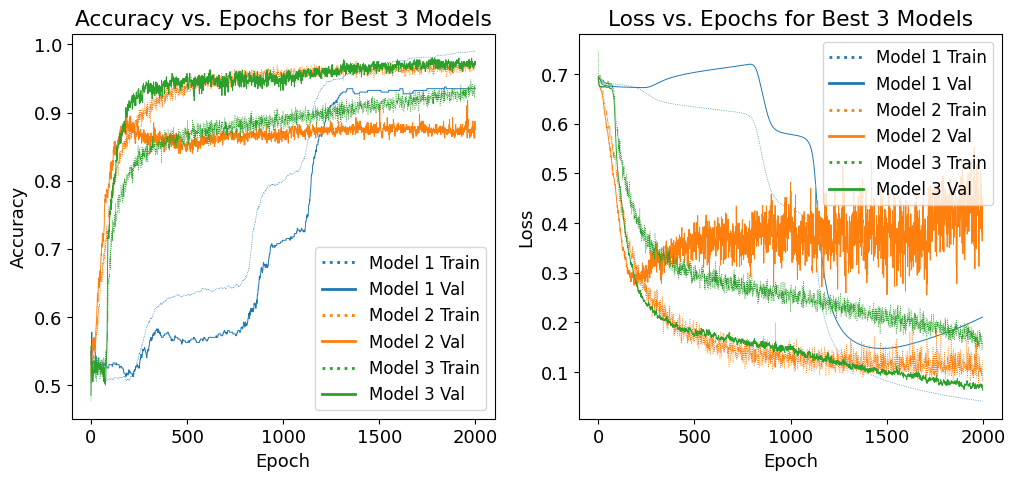

In [33]:
N = 3
# Select a colormap with 10 distinct colors and with .colors access the list containing the RGB values of the colors in the colormap
colors = plt.get_cmap("tab10").colors

# Create the canvas for two sublots
fig, AX = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax = AX[0]
for n in range(N):
    df = pd.read_csv(os.path.join(best_models_folder_path, f"best_model_{n}_training_log.csv"))
    ax.plot(df['epoch'], df['accuracy'], label=f"Model {n+1} Train", c=colors[n], ls=":", linewidth = 0.5)
    ax.plot(df['epoch'], df['val_accuracy'], label=f"Model {n+1} Val", c=colors[n], linewidth = 0.7)

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. Epochs for Best 3 Models")
handles, labels = ax.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], color=h.get_color(), linestyle=h.get_linestyle(), linewidth=2) for h in handles]
ax.legend(new_handles, labels, fontsize=12, handlelength=2)


# Plot Loss
ax = AX[1]
for n in range(N):
    df = pd.read_csv(os.path.join(best_models_folder_path, f"best_model_{n}_training_log.csv"))
    ax.plot(df['epoch'], df['loss'], label=f"Model {n + 1} Train", c=colors[n], ls=":", linewidth = 0.5)
    ax.plot(df['epoch'], df['val_loss'], label=f"Model {n + 1} Val", c=colors[n], linewidth = 0.7)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title(f"Loss vs. Epochs for Best {N} Models")
handles, labels = ax.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], color=h.get_color(), linestyle=h.get_linestyle(), linewidth=2) for h in handles]
ax.legend(new_handles, labels, fontsize=12, handlelength=2)

plt.show()

### k-fold cross validation over the best models

Compute the STANDARD DEVIATION associated to the accuracy, across the folds. 
This way you can make a meaningful comparison (compatibility). 


In [35]:
N = 3 # best models to compare
k = 5  
df = pd.read_csv(os.path.join("ex1_results", "tuner_results", "summary_results.csv"))
model_accuracies = {}
best_hps = []

for n in range(N):
        # Retrieve hyperparameters
        act = df["activation"].iloc[n]
        drop = df["dropout_rate"].iloc[n]
        learn = df["learning_rate"].iloc[n]
        opt = df ["optimizer"].iloc[n]
        custom_hp = keras_tuner.HyperParameters()
        custom_hp.Fixed("activation", act)
        custom_hp.Fixed("dropout_rate", drop)
        custom_hp.Fixed("learning_rate", learn)
        custom_hp.Fixed("optimizer", opt)
        best_hps.append(custom_hp)

# Perform K-Fold Cross-Validation for each model
for i, bhp in enumerate(best_hps):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)  # KFold object
    fold_accuracies = []
    model=build_model(bhp)

    for train_idx, test_idx in kfold.split(x_train, y_train):  # Splitting indices
        X_train_fold, X_test_fold = x_train[train_idx], x_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

        model.fit(X_train_fold, y_train_fold, epochs=epoch, batch_size=bat, verbose=0)

        _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        fold_accuracies.append(accuracy)

    # Store accuracy results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    model_accuracies[f"Model {i+1}"] = (mean_accuracy, std_accuracy)

    print(f"Model {i+1} -> Mean Validation Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")

Model 1 -> Mean Validation Accuracy: 0.7131, Std Dev: 0.0906
Model 2 -> Mean Validation Accuracy: 0.9313, Std Dev: 0.0226
Model 3 -> Mean Validation Accuracy: 0.9475, Std Dev: 0.0210


### Test of best model

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


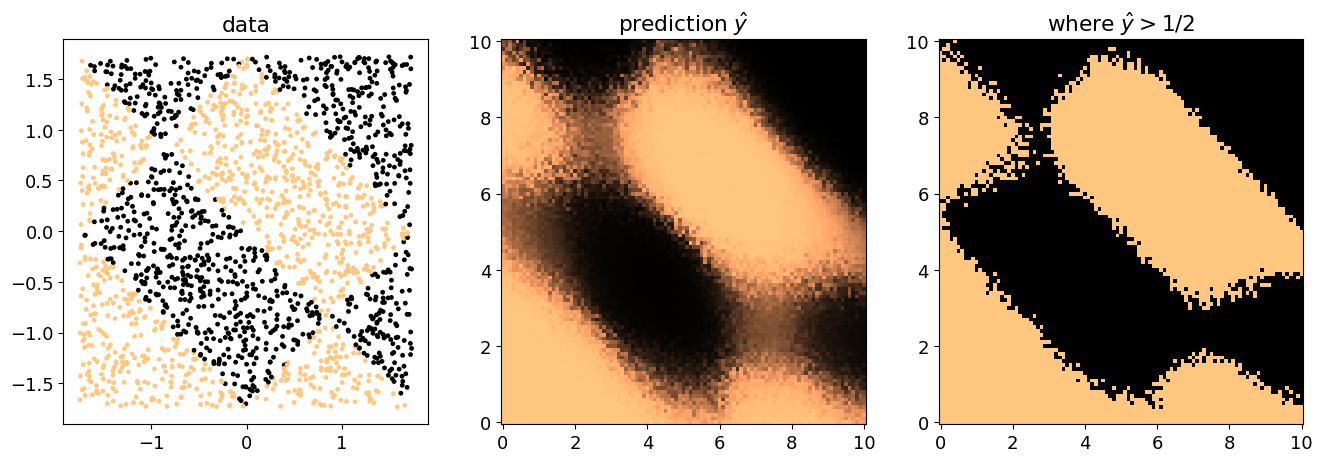

In [36]:
# Select the best model
index = 2 # model to test

# Retrieve hyperparameters
df = pd.read_csv(os.path.join("ex1_results", "tuner_results", "summary_results.csv"))
act = df["activation"].iloc[index]
drop = df["dropout_rate"].iloc[index]
learn = df["learning_rate"].iloc[index]
opt = df ["optimizer"].iloc[index]
custom_hp = keras_tuner.HyperParameters()
custom_hp.Fixed("activation", act)
custom_hp.Fixed("dropout_rate", drop)
custom_hp.Fixed("learning_rate", learn)
custom_hp.Fixed("optimizer", opt)

# Build the model with the retrieved hyperparameters
model = build_model(custom_hp)

# Train the model
model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=400,  # more epochs to ensure that it reaches its max achievable accuracy
        batch_size=32,
        verbose=0, # to prevent overfitting
    )

# dX defines the step size for generating a grid of points for predictions. This means that the grid will cover a range from 0 to 10 (with a step of 0.1).
# The mesh grid that will be created later will have a spacing of 0.1 between adjacent points.
dX = .1
B=10 # Scale the values bt B = 10. This helps control the range or magnitude of the features (likely for scaling or ensuring the grid has a reasonable range).

X1 = np.arange(0,10+dX, dX) 
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))

grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
# Standardize so that input features to the model are on the same scale as the training data
grid_r=Standardize(grid,x_mean,x_std)

# Make the predictions for grid_r
pred = model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))

ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")

ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")

ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0

ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show() 

# 2. Data augmentation and reduction

In [13]:
n_point = 5
nepoch = 100
reduction = np.linspace(0.1, 0.9, n_point)
augmentation = np.linspace(1, 10, n_point).astype(int)  # Must be integer
batch_sizes = np.linspace(10, 60, n_point).astype(int)


# Store results
red_accuracies_mean, aug_accuracies_mean, bat_accuracies, bat_loss = [], [], [], []

for red, aug, bat in zip(reduction, augmentation, batch_sizes):
    # =================== REDUCTION ===================
    n_reduced = int((1 - red) * len(x_train))
    idx_reduced = np.random.choice(len(x_train), n_reduced, replace=False)
    x_train_reduced, y_train_reduced = x_train[idx_reduced], y_train[idx_reduced]

    # =================== DATA AUGMENTATION ===================
    noise = np.random.normal(0, 1e-2, x_train.shape)
    x_train_augmented = np.repeat(x_train, aug, axis=0) + np.repeat(noise, aug, axis=0)
    y_train_augmented = np.repeat(y_train, aug)

    temp_reduction, temp_augmentation, temp_batch, temp_bat_loss = [], [], [], []

    for _ in range(5):  
        # =================== REDUCTION ===================
        best_model = build_model(custom_hp)
        history_reduced = best_model.fit(x_train_reduced, y_train_reduced, 
                                         epochs=nepoch, 
                                         batch_size=bat, 
                                         validation_data=(x_valid, y_valid),
                                         verbose=0)
        temp_reduction.append(history_reduced.history["val_accuracy"])

        # =================== DATA AUGMENTATION ===================
        best_model = build_model(custom_hp)
        history_augmentation = best_model.fit(x_train_augmented, y_train_augmented, 
                                              epochs=nepoch, 
                                              batch_size=bat, 
                                              validation_data=(x_valid, y_valid),
                                              verbose=0)
        temp_augmentation.append(history_augmentation.history["val_accuracy"])

        # =================== BATCH TRAINING ===================
        best_model = build_model(custom_hp)
        history_batch = best_model.fit(x_train, y_train, 
                                       epochs=nepoch, 
                                       batch_size=bat,
                                       validation_data=(x_valid, y_valid), 
                                       verbose=0)

        temp_batch.append(history_batch.history["accuracy"])  # Store accuracy values
        temp_bat_loss.append(history_batch.history["loss"])   # Store loss values  

    # Averaging reduction & augmentation metrics
    red_accuracies_mean.append(np.mean(temp_reduction, axis=0))  
    aug_accuracies_mean.append(np.mean(temp_augmentation, axis=0))

    # Store full histories for batch training
    bat_accuracies.append(np.mean(temp_batch, axis=0))  # Average across trials
    bat_loss.append(np.mean(temp_bat_loss, axis=0))  

# Convert to NumPy arrays for easier plotting

red_accuracies = np.array(np.mean(red_accuracies_mean,axis=1))
aug_accuracies = np.array(np.mean(aug_accuracies_mean,axis=1))
bat_accuracies = np.array(bat_accuracies)
bat_loss = np.array(bat_loss)

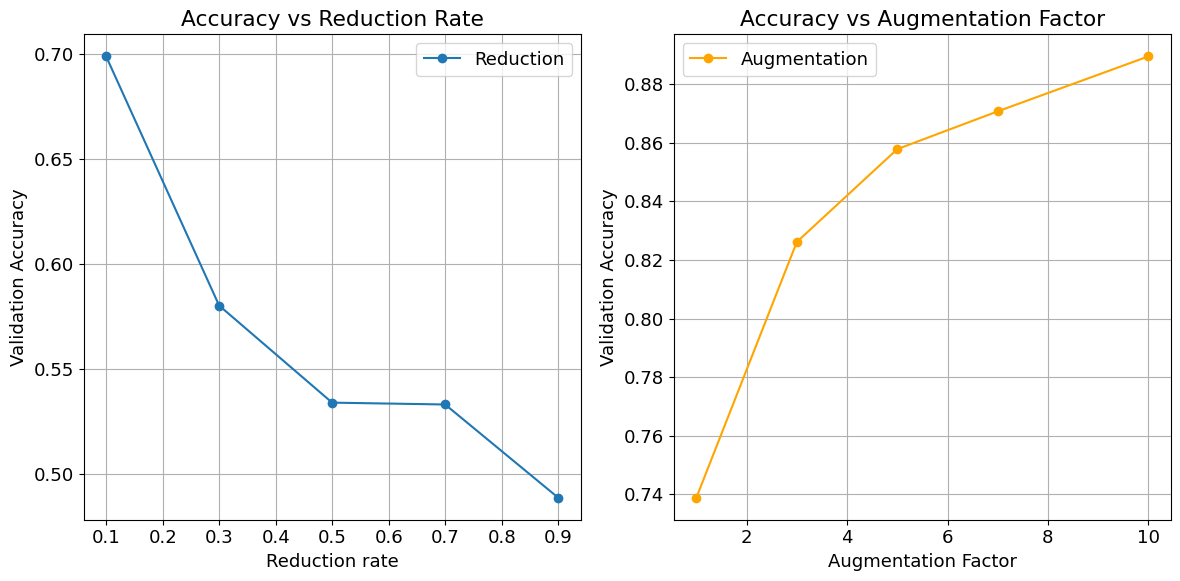

In [14]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot for reduction
plt.subplot(1, 2, 1)
plt.plot(reduction, red_accuracies, marker='o', label='Reduction')
plt.xlabel('Reduction rate')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Reduction Rate')
plt.grid(True)
plt.legend()

# Plot for augmentation
plt.subplot(1, 2, 2)
plt.plot(augmentation, aug_accuracies, marker='o', label='Augmentation', color='orange')
plt.xlabel('Augmentation Factor')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Augmentation Factor')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

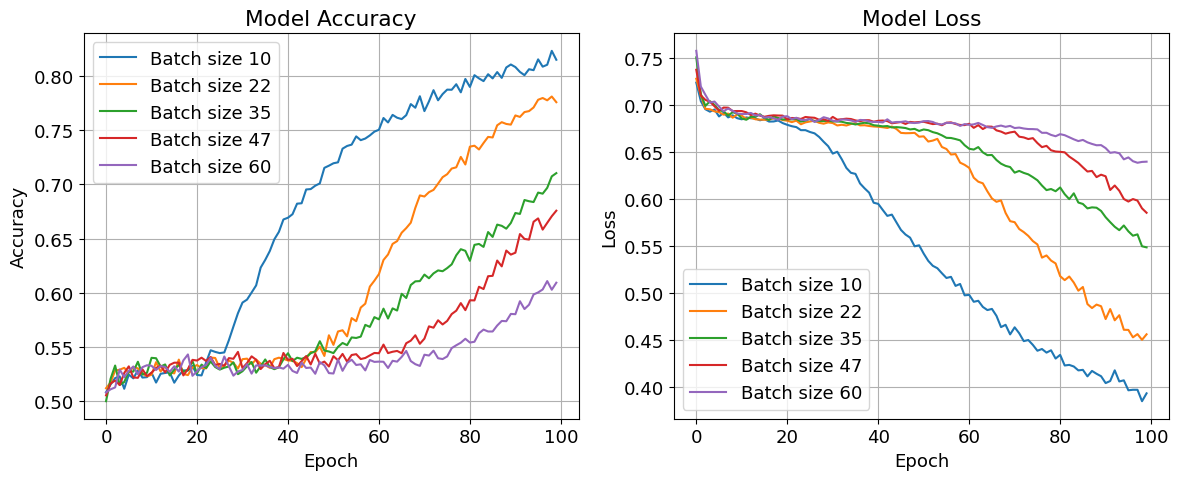

In [15]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for i in range(len(batch_sizes)):
    plt.plot(bat_accuracies[i], label=f'Batch size {batch_sizes[i]}')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
for i in range(len(batch_sizes)):
    plt.plot(bat_loss[i], label=f'Batch size {batch_sizes[i]}')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()